In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [15]:
wine_quality = fetch_ucirepo(id=186)
# Pre-processing
df = wine_quality.data.original


def categorize_quality(quality):
    if quality < 7:
        return 'bad'
    else:
        return 'good'


df['quality_category'] = df['quality'].apply(categorize_quality)

red_wine_df = df[df['color'] == 'red']
white_wine_df = df[df['color'] == 'white']

df_array = [red_wine_df, white_wine_df, df]

In [ ]:
def get_probability_scores(model, X_test):
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_test) # For models that support probability prediction
        good_index = list(model.classes_).index('good')
        return probabilities[:, good_index]
    elif hasattr(model, 'decision_function'): # For models with decision function 
        return model.decision_function(X_test)
    else:
        predictions = model.predict(X_test) # Fallback: use predicted class as binary score (not ideal for PR curve)
        return (predictions == 'good').astype(int)
    
def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0

    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds

    print(f"Best Folds: {best_folds} | Best Score: {best_score}")
    return best_folds


def plot_roc_curves(models_results, X_test, y_test):
    plt.figure(figsize=(12, 8))

    colors = ['blue', 'green', 'red', 'purple', 'orange']

    auc_scores = {}

    for i, (model_name, result) in enumerate(models_results.items()):
        y_scores = result['scores']

        fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label='good')
        auc_score = roc_auc_score(y_test, y_scores)

        auc_scores[model_name] = auc_score

        plt.plot(fpr, tpr, linewidth=2.5, color=colors[i],
                 label=f'{model_name} (AUC = {auc_score:.3f})')

    # random guess baseline
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1,label='Random Classifier (AUC = 0.500)')

    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve Comparison - All Models (Combined Wine Dataset)',fontsize=16, pad=20)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.tight_layout()
    plt.show()

In [19]:
def train_svm(X_train, X_test, y_train):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svm = SVC(random_state=42, kernel='rbf', probability=True)
    svm.fit(X_train, y_train)

    y_scores_svm = get_probability_scores(svm, X_test)
    return {
        'model': svm,
        'scores': y_scores_svm,
        'best_params': {}
    }


def train_qda(X_train, X_test, y_train):
    folds = optimized_folds(QuadraticDiscriminantAnalysis(), X_train, y_train)

    # find optimixed priors
    priors = []
    for low_prior in np.arange(0.05, 0.36, 0.1):  
        high_prior = 1.0 - low_prior  
        priors.append([round(low_prior, 2), round(high_prior, 2)])

    param_grid = {'priors': priors}
    grid_search = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid, cv=folds)
    grid_search.fit(X_train, y_train)

    qda = QuadraticDiscriminantAnalysis(priors=grid_search.best_params_["priors"])
    qda.fit(X_train, y_train)

    y_scores_qda = get_probability_scores(qda, X_test)
    return {
        'model': qda,
        'scores': y_scores_qda,
        'best_params': grid_search.best_params_
    }


def train_random_forest(X_train, X_test, y_train):
    rf_param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                   rf_param_dist, cv=5, n_iter=10,
                                   scoring='f1_macro', random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    rf_best = rf_random.best_estimator_

    y_scores_rf = get_probability_scores(rf_best, X_test)
    return {
        'model': rf_best,
        'scores': y_scores_rf,
        'best_params': rf_random.best_params_
    }


def train_decision_tree(X_train, X_test, y_train):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)

    y_scores_dt = get_probability_scores(dt, X_test)
    return {
        'model': dt,
        'scores': y_scores_dt,
        'best_params': {}
    }


def train_knn(X_train, X_test, y_train):
    folds = optimized_folds(KNeighborsClassifier(), X_train, y_train)

    knn_param_grid = {'n_neighbors': range(1, 21)}
    knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=folds, scoring='f1_macro')
    knn_grid.fit(X_train, y_train)
    knn_best = knn_grid.best_estimator_

    y_scores_knn = get_probability_scores(knn_best, X_test)
    return {
        'model': knn_best,
        'scores': y_scores_knn,
        'best_params': knn_grid.best_params_
    }

  Training KNN...
  Training Decision Tree...
  Training Random Forest...
  Training QDA...
  Training SVM...


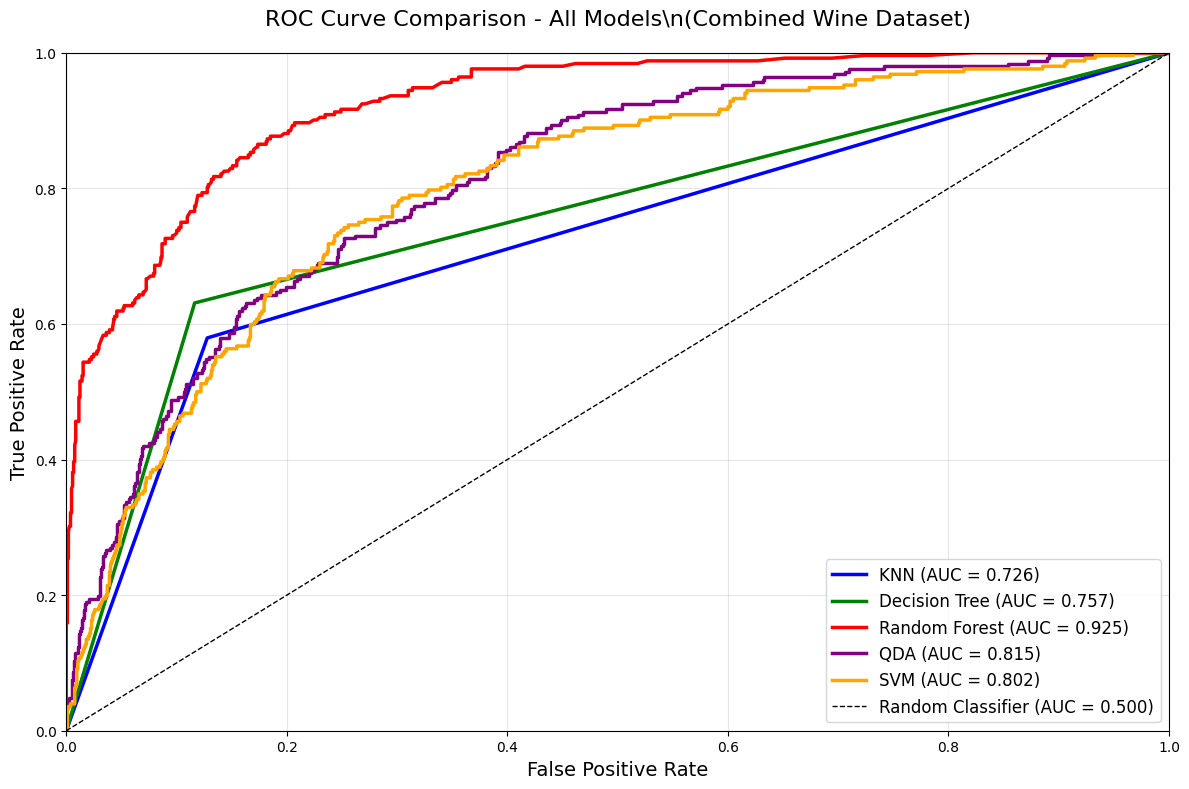

In [ ]:
# Comprehensive ROC Curve Comparison for All Models
def compare_all_models_roc():
    combined_wine = df_array[2]
    X = combined_wine.drop(['quality', 'quality_category', 'color'], axis=1)
    y = combined_wine['quality_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    models_results = {}


    print("  Training KNN...")
    models_results["KNN"] = train_knn(X_train, X_test, y_train)

    print("  Training Decision Tree...")
    models_results["Decision Tree"] = train_decision_tree(X_train, X_test, y_train)

    print("  Training Random Forest...")
    models_results["Random Forest"] = train_random_forest(X_train, X_test, y_train)

    print("  Training QDA...")
    models_results["QDA"] = train_qda(X_train, X_test, y_train)

    print("  Training SVM...")
    models_results["SVM"] = train_svm(X_train, X_test, y_train)

    plot_roc_curves(models_results, X_test, y_test)


compare_all_models_roc()